# Predicting Stock Movements from Twitter Data

In [355]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from math import floor, ceil
from datetime import datetime, date, timedelta
import os
from sklearn.metrics import f1_score, confusion_matrix
import random
import tensorflow as tf
from sklearn import svm

## Preprocess the Twitter Data

In [279]:
twitter_data = pd.read_csv(os.getcwd() + '/data/Raw_tweets_09_30.csv', \
                           usecols=['created_at', 'tweet_text'], \
                           parse_dates=['created_at'])
twitter_data.rename({'tweet_text': 'content'}, inplace=True, axis='columns')
twitter_data

,created_at,content
0,2019-06-24 17:58:26,Nouriel Roubini outlines the 2020 recession ri...
1,2019-06-24 17:58:33,@nyika_yedu The multi currency regime dealt wi...
2,2019-06-24 17:58:35,@jwoltmann @starboard_light People ARE paying ...
3,2019-06-24 17:58:46,"The caution continues. ""Small business owners ..."
4,2019-06-24 17:59:00,Mapping The World's Financial Weak Spots - htt...
...,...,...
1375259,2019-09-30 13:19:32,Band nerds can never know about me and the sto...
1375260,2019-09-30 13:19:33,@realDonaldTrump You manipulated a fake phone ...
1375261,2019-09-30 13:19:39,@Ian_Fraser USA SCARY SIGNS OF RECESSION - RET...
1375262,2019-09-30 13:19:41,"@TexMinIndia @nsitharaman.dear medam / sirs, D..."


In [280]:
before_drop_len = len(twitter_data)
dropped_count = pd.DataFrame(columns=['Number dropped'])

# Drop rows with missing values
twitter_data.dropna(axis='index', inplace=True)
dropped_count.loc['NA'] = (before_drop_len-len(twitter_data),)
before_drop_len = len(twitter_data)

# Drop rows with hyperlinks
url_regex = r'http[s]?:\/\/t\.co\/[a-z,A-Z,0-9]+'
no_urls = twitter_data['content'].str.contains(url_regex)
indicies_to_drop = [df_index for df_index in twitter_data.index if no_urls[df_index]]
twitter_data.drop(index=indicies_to_drop, inplace=True)
dropped_count.loc['Hyperlinks'] = (before_drop_len-len(twitter_data),)

In [281]:
# Drop days not between June 24 2019 to September 27 2019 to match stock data
after_sep_27 = twitter_data['created_at'].dt.date >= date(2019, 9, 27)
print(f'after sep 27: {after_sep_27.value_counts()}' )
before_june_5  = twitter_data['created_at'].dt.date <= date(2019, 6, 24)
print(f'before june 25: {before_june_5.value_counts()}' )
date_filter = ~(after_sep_27 | before_june_5)
print(f'date filter: {date_filter.value_counts()}' )
twitter_data = twitter_data[date_filter]

after sep 27: False    667309
True      14284
Name: created_at, dtype: int64
before june 25: False    679646
True       1947
Name: created_at, dtype: int64
date filter: True     665362
False     16231
Name: created_at, dtype: int64


In [358]:
# Sum up total dropped
dropped_count.loc['Total'] = (dropped_count['Number dropped'].sum(),)
display(dropped_count)

display(twitter_data)

,Number dropped
NA,270632
Hyperlinks,423039
Total,1387342


,created_at,content,sentiment
3697,2019-06-25 00:02:03,@GuiAttizzaniMD @MountSinaiHeart We’ve publish...,-0.1232
3720,2019-06-25 00:04:37,@IlhanMN How about putting a cap on interest a...,0.7814
3735,2019-06-25 00:05:59,@HongPong @FennyFen @AndrewYang Taxing stock t...,-0.7007
3757,2019-06-25 00:09:07,"@scottmelker True, but no one is stopping them...",-0.7856
3775,2019-06-25 00:10:59,@yashar 1.6 trillion more money the government...,0.4215
...,...,...,...
1342294,2019-09-26 23:15:39,@harmonylion1 Could you explain where the valu...,0.7783
1342421,2019-09-26 23:33:12,@AndrewYang although I'm not a supporter of yo...,0.0489
1342443,2019-09-26 23:36:18,@RubinsBlockList @BernieSanders Every prole to...,0.7272
1342460,2019-09-26 23:39:16,@Raymond80730582 @WandaLStroud @Joe19705 @bbcq...,-0.0772


In [283]:
# See if filtering with expressive words is practical
expressive_words = ['I\'m', 'I am', 'feel', 'feels', 'bull', 'bear', 'makes me']
expressive_words_regex = re.compile('\s|'.join(expressive_words))
has_expressive = twitter_data['content'].str.contains(expressive_words_regex)
expressive_data_subset = twitter_data[has_expressive]
for c in expressive_data_subset['content'][:7]:
    print(c, '\n\n')

@GuiAttizzaniMD @MountSinaiHeart We’ve published in JACC Intv on &gt;683mm2 annuli with 29S3. 1y data presented at #ACC19. Not sure largest annulus treatable by 34 Evolut but we’ve used 31 CoreValve and implant at 0 depth. We feel 29S3 more adjustable with inflation to conform to largest anatomy. 


@IlhanMN How about putting a cap on interest and checking tuition inflation?  I am fine paying for my education. But the inflation of when I started college and ended college was insane.  2% interest to 6.5% interest in government loans and tuition doubled in my college career. 


@HongPong @FennyFen @AndrewYang Taxing stock transactions will turn the market into something where there isn't fluidity, people will be punished for wanting to invest, there will be substantially less volume traded.

I'm liberal as fuck, but this isn't the play chief. 


@scottmelker True, but no one is stopping them from picking up 2 or 8 books with teachings in the stock market. Learning on CT is the lazy and i

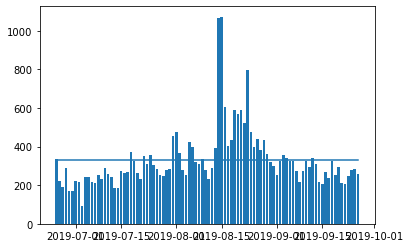

In [284]:
expressive_dates = [d.date() for d in expressive_data_subset['created_at']]
sorted_dates = list(set([a.date() for a in twitter_data['created_at']]))
sorted_dates.sort()
num_expressive_per_day = [expressive_dates.count(date) for date in sorted_dates]
plt.bar(sorted_dates, num_expressive_per_day)
plt.plot(sorted_dates, [np.mean(num_expressive_per_day)] * len(sorted_dates))
plt.show()

In [285]:
twitter_data = expressive_data_subset
dates = expressive_dates
twitter_data

,created_at,content
3697,2019-06-25 00:02:03,@GuiAttizzaniMD @MountSinaiHeart We’ve publish...
3720,2019-06-25 00:04:37,@IlhanMN How about putting a cap on interest a...
3735,2019-06-25 00:05:59,@HongPong @FennyFen @AndrewYang Taxing stock t...
3757,2019-06-25 00:09:07,"@scottmelker True, but no one is stopping them..."
3775,2019-06-25 00:10:59,@yashar 1.6 trillion more money the government...
...,...,...
1342294,2019-09-26 23:15:39,@harmonylion1 Could you explain where the valu...
1342421,2019-09-26 23:33:12,@AndrewYang although I'm not a supporter of yo...
1342443,2019-09-26 23:36:18,@RubinsBlockList @BernieSanders Every prole to...
1342460,2019-09-26 23:39:16,@Raymond80730582 @WandaLStroud @Joe19705 @bbcq...


In [286]:
# Publish as training data to use for human_rater.py
with open('./data/preprocessed_twitter.csv', 'w+') as preprocessed_data_file:
    twitter_data.to_csv(preprocessed_data_file, index_label=False)

## Preprocessing the Stock Data

In [262]:
stock_data = pd.read_csv(os.getcwd() + '/data/prices_daily.csv', 
                         dtype={'DJIA CLOSE': np.float64, 'SP500 CLOSE': np.float64},
                         parse_dates=['Dates'],
                         index_col='Dates')

stock_data = stock_data.rename(columns={'DJIA CLOSE': 'DOW', 'SP500 CLOSE': 'SP'})
# TODO: maybe add this column back in
stock_data.drop(columns=['VIX CLOSE'], inplace=True)
stock_data.sort_index()
num_days = (stock_data.index[-1] - stock_data.index[0]).days
days = [stock_data.index[0] + timedelta(days=i) for i in range(num_days)]
stock_data = stock_data.reindex(days)
stock_data

,DOW,SP
Dates,,
2019-06-24,26727.54,2945.35
2019-06-25,26548.22,2917.38
2019-06-26,26536.82,2913.78
2019-06-27,26526.58,2924.92
2019-06-28,26599.96,2941.76
...,...,...
2019-09-22,NaN,NaN
2019-09-23,26949.99,2991.78
2019-09-24,26807.77,2966.60


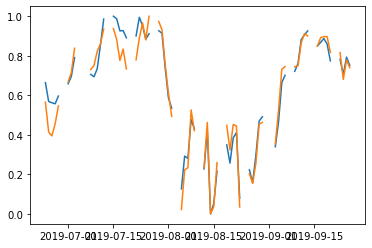

In [263]:
def normalize(series):
    series = series- np.min(series)
    return series/np.max(series)


plt.plot(stock_data.index, normalize(stock_data['DOW']))
plt.plot(stock_data.index, normalize(stock_data['SP']))
plt.show()

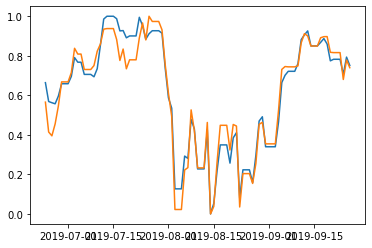

In [265]:
# First build a series from the current series that includes all dates
def find_next_value(series, start_date):
    curr_date = start_date
    while pd.isnull(series[curr_date]):
        curr_date += timedelta(days=1)
    return series[curr_date]

def fill_in_missing(time_series):
    prev_closing = None
    for date, closing_value in time_series.items():
        if pd.isnull(closing_value):
            next_value = find_next_value(time_series, date)
            if prev_closing is not None:
                time_series[date] = next_value
            else:
                time_series[date] = np.mean([next_value, prev_closing])
        prev_closing = time_series[date]

    return time_series

stock_data['DOW'] = fill_in_missing(stock_data['DOW'])
stock_data['SP'] = fill_in_missing(stock_data['SP'])

plt.plot(stock_data.index, normalize(stock_data['DOW']))
plt.plot(stock_data.index, normalize(stock_data['SP']))
plt.show()

,DOW,SP,DOW_delta,SP_delta
Dates,,,,
2019-06-24,26727.54,2945.35,NaN,NaN
2019-06-25,26548.22,2917.38,179.32,27.97
2019-06-26,26536.82,2913.78,11.40,3.60
2019-06-27,26526.58,2924.92,10.24,-11.14
2019-06-28,26599.96,2941.76,-73.38,-16.84
...,...,...,...,...
2019-09-22,26949.99,2991.78,0.00,0.00
2019-09-23,26949.99,2991.78,0.00,0.00
2019-09-24,26807.77,2966.60,142.22,25.18


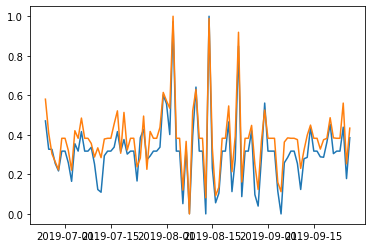

In [266]:
# Add delta column
def delta_for_col(col_series):
    return [col_series[date]-col_series[prev_date] for date, prev_date in zip(col_series.index,col_series.index[1:])]
    
stock_data['DOW_delta']  = [None] + delta_for_col(stock_data['DOW'])
stock_data['SP_delta'] = [None] + delta_for_col(stock_data['SP'])
display(stock_data)

# Drop the first row
stock_data.drop(index=stock_data.index[0], inplace=True)

plt.plot(stock_data.index, normalize(stock_data['DOW_delta']))
plt.plot(stock_data.index, normalize(stock_data['SP_delta']))
plt.show()

,DOW,SP,DOW_delta,SP_delta,z_score
Dates,,,,,
2019-06-25,26548.22,2917.38,179.32,27.97,-0.449639
2019-06-26,26536.82,2913.78,11.40,3.60,-0.495545
2019-06-27,26526.58,2924.92,10.24,-11.14,-0.397088
2019-06-28,26599.96,2941.76,-73.38,-16.84,-0.163141
2019-06-29,26717.43,2964.33,-117.47,-22.57,0.168723
...,...,...,...,...,...
2019-09-22,26949.99,2991.78,0.00,0.00,0.658251
2019-09-23,26949.99,2991.78,0.00,0.00,0.658251
2019-09-24,26807.77,2966.60,142.22,25.18,0.277315


count    9.400000e+01
mean     4.564906e-16
std      1.005362e+00
min     -2.219559e+00
25%     -7.837401e-01
50%      3.666223e-01
75%      8.397934e-01
max      1.269028e+00
Name: z_score, dtype: float64

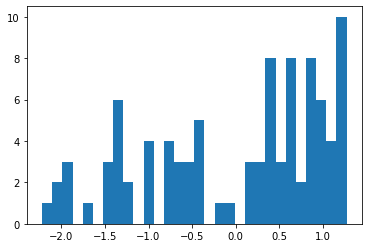

In [267]:
# Add z score column
def z_score_col(col_series):
    std = np.std(col_series)
    mean = np.mean(col_series)
    return pd.Series([(x_i - mean)/std for x_i in col_series],index=col_series.index)

combined_sp_and_dow = (normalize(stock_data['SP']) + normalize(stock_data['DOW']))/2
stock_data['z_score'] = z_score_col(combined_sp_and_dow)
display(stock_data)

display(stock_data['z_score'].describe())
plt.hist(stock_data['z_score'], bins=30)
plt.show()

## Build a Financial Sentiment Analyzer from VADER

In [293]:
financial_lexicon = pd.read_csv(os.getcwd() + '/data/stock_lex.csv', dtype={
    'Aff_Score': np.float64,
    'Neg_Score': np.float64
})
financial_lexicon['sentiment'] = (financial_lexicon['Aff_Score'] + financial_lexicon['Neg_Score'])/2
financial_lexicon

,Item,POS,Aff_Score,Neg_Score,sentiment
0,'em,PR,0.379542,0.533419,0.456481
1,'n,CC,1.413176,1.199917,1.306547
2,'n handle,NaN,2.839000,2.941000,2.890000
3,'s a,NaN,-0.023077,-0.013615,-0.018346
4,'s abc,NaN,2.261667,2.300000,2.280833
...,...,...,...,...,...
20545,zoom,VB,-0.652273,-0.649174,-0.650723
20546,zortrades.com,NN,2.141000,2.163000,2.152000
20547,zte,NN,4.934000,5.084000,5.009000
20548,zuck,NN,-0.237857,-0.185172,-0.211515


In [294]:
# mutate the stock_lex.csv to match the sentiment file that vader expects
stock_lexicon = pd.read_csv('./data/stock_lex.csv').drop(columns='POS')
stock_lexicon

,Item,Aff_Score,Neg_Score
0,'em,0.379542,0.533419
1,'n,1.413176,1.199917
2,'n handle,2.839000,2.941000
3,'s a,-0.023077,-0.013615
4,'s abc,2.261667,2.300000
...,...,...,...
20545,zoom,-0.652273,-0.649174
20546,zortrades.com,2.141000,2.163000
20547,zte,4.934000,5.084000
20548,zuck,-0.237857,-0.185172


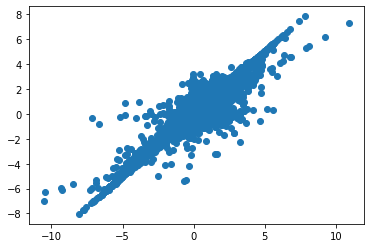

In [295]:
plt.scatter(stock_lexicon['Aff_Score'], stock_lexicon['Neg_Score'])
plt.show()

In [296]:
stock_lexicon['sentiment'] = (stock_lexicon['Aff_Score'] + stock_lexicon['Neg_Score'])/2
stock_lexicon.drop(columns=['Aff_Score', 'Neg_Score'], inplace=True, errors='ignore')
stock_lexicon.rename(columns={'Item': 'word'}, inplace=True)
stock_lexicon

,word,sentiment
0,'em,0.456481
1,'n,1.306547
2,'n handle,2.890000
3,'s a,-0.018346
4,'s abc,2.280833
...,...,...
20545,zoom,-0.650723
20546,zortrades.com,2.152000
20547,zte,5.009000
20548,zuck,-0.211515


In [297]:
# Convert to a format vader can understand
stock_lexicon_str_list = []
for i in range(len(stock_lexicon)):
    row = stock_lexicon.iloc[i]
    stock_lexicon_str_list.append('{}\t{}'.format(row['word'], row['sentiment']))
stock_lexicon_str = '\n'.join(stock_lexicon_str_list)

In [298]:
# Hacky solution for adding a custom lexicon
sentiment_analyzer = SentimentIntensityAnalyzer()
sentiment_analyzer.lexicon_full_filepath = stock_lexicon_str
sentiment_analyzer.lex_dict = sentiment_analyzer.make_lex_dict()

## Testing the Assigned Sentiments vs Ground Truth

In [303]:
human_rated_tweets = pd.read_csv('./data/human_rated_tweets.csv')
human_rated_tweets.head(15)

,Unnamed: 0,created_at,content,true_sentiment
0,178,2019-06-24 18:21:00,@TechQn @DiMartinoBooth @paranoidbull Japan ha...,-1
1,189,2019-06-24 18:21:55,@VDalal1074 @DrAllahNizar_ @UN That's why Indi...,0
2,272,2019-06-24 18:28:00,@ScottNations So true and well said. I'm still...,-1
3,324,2019-06-24 18:30:45,@NorthmanTrader @HuXijin_GT That's what I'm ho...,-3
4,348,2019-06-24 18:32:18,@BharathQuant @ByeByeMarket @LeederOfThePack I...,-3
5,371,2019-06-24 18:34:11,@RandomGuySpain @starwart1 I'm so sorry y'all ...,-3
6,377,2019-06-24 18:34:44,@B_Paul06 So apparently he was booked in biz c...,0
7,420,2019-06-24 18:37:54,Small political tweet incoming. I can't help b...,2
8,475,2019-06-24 18:42:07,@matthew_peirson Tax break? A one time check v...,0
9,514,2019-06-24 18:45:31,@AttackingCB Yeah I think that is the main rea...,1


In [304]:
vader_ratings = []
for tweet in human_rated_tweets['content']:
    polarity = sentiment_analyzer.polarity_scores(tweet)
    vader_ratings.append(polarity['compound'])
human_rated_tweets['vader_sentiment'] = vader_ratings
human_rated_tweets.head(15)

,Unnamed: 0,created_at,content,true_sentiment,vader_sentiment
0,178,2019-06-24 18:21:00,@TechQn @DiMartinoBooth @paranoidbull Japan ha...,-1,-0.0516
1,189,2019-06-24 18:21:55,@VDalal1074 @DrAllahNizar_ @UN That's why Indi...,0,0.0516
2,272,2019-06-24 18:28:00,@ScottNations So true and well said. I'm still...,-1,0.7056
3,324,2019-06-24 18:30:45,@NorthmanTrader @HuXijin_GT That's what I'm ho...,-3,0.2500
4,348,2019-06-24 18:32:18,@BharathQuant @ByeByeMarket @LeederOfThePack I...,-3,0.2589
5,371,2019-06-24 18:34:11,@RandomGuySpain @starwart1 I'm so sorry y'all ...,-3,0.5939
6,377,2019-06-24 18:34:44,@B_Paul06 So apparently he was booked in biz c...,0,0.1154
7,420,2019-06-24 18:37:54,Small political tweet incoming. I can't help b...,2,-0.7999
8,475,2019-06-24 18:42:07,@matthew_peirson Tax break? A one time check v...,0,0.7536
9,514,2019-06-24 18:45:31,@AttackingCB Yeah I think that is the main rea...,1,-0.9144


In [306]:
vader_positives = human_rated_tweets['vader_sentiment'] > 0
true_positives = human_rated_tweets['true_sentiment'] > 0
random_positives = [random.randint(0,1) > 0 for i in range(len(human_rated_tweets))]
vader_f1 = f1_score(true_positives, vader_positives)
random_f1 = f1_score(true_positives, random_positives)
pd.DataFrame({'F1 Score': [vader_f1, random_f1]}, index=['Vader', 'Random Guessing'])

,F1 Score
Vader,0.434783
Random Guessing,0.529412


In [307]:
confusion_mat = confusion_matrix(true_positives, vader_positives)
pd.DataFrame({'Predicted Positive': confusion_mat.T[1], 'Predicted Negative': confusion_mat.T[0]}, index=['True Negative', 'True Positive'])


,Predicted Positive,Predicted Negative
True Negative,24,15
True Positive,10,2


In [308]:
twitter_data['sentiment'] = [sentiment_analyzer.polarity_scores(word)['compound'] for word in twitter_data['content']]
twitter_data

<ipython-input-308-54c1c39d7670>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_data['sentiment'] = [sentiment_analyzer.polarity_scores(word)['compound'] for word in twitter_data['content']]


,created_at,content,sentiment
3697,2019-06-25 00:02:03,@GuiAttizzaniMD @MountSinaiHeart We’ve publish...,-0.1232
3720,2019-06-25 00:04:37,@IlhanMN How about putting a cap on interest a...,0.7814
3735,2019-06-25 00:05:59,@HongPong @FennyFen @AndrewYang Taxing stock t...,-0.7007
3757,2019-06-25 00:09:07,"@scottmelker True, but no one is stopping them...",-0.7856
3775,2019-06-25 00:10:59,@yashar 1.6 trillion more money the government...,0.4215
...,...,...,...
1342294,2019-09-26 23:15:39,@harmonylion1 Could you explain where the valu...,0.7783
1342421,2019-09-26 23:33:12,@AndrewYang although I'm not a supporter of yo...,0.0489
1342443,2019-09-26 23:36:18,@RubinsBlockList @BernieSanders Every prole to...,0.7272
1342460,2019-09-26 23:39:16,@Raymond80730582 @WandaLStroud @Joe19705 @bbcq...,-0.0772


/Users/hazimmohamed/opt/anaconda3/lib/python3.8/site-packages/pandas/core/base.py:1480: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  return self._update_inplace(result)


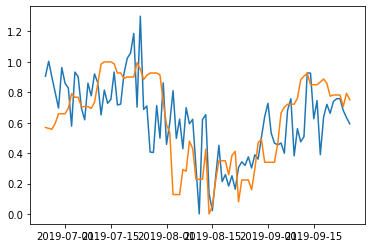

In [309]:
days = twitter_data['created_at'].dt.date
days.drop_duplicates(inplace=True)
daily_sentiment = [np.mean(twitter_data[twitter_data['created_at'].dt.date == day]['sentiment']) for day in days]
plt.plot(days[:], normalize(daily_sentiment)*1.3)
plt.plot(stock_data.index, normalize(stock_data['DOW']))
plt.show()

## Formatting the Data as A Supervised Learning Problem

In [324]:
sentiment_time_series = np.array(daily_sentiment).reshape((1,-1))
stock_data_time_series = stock_data.transpose().to_numpy()
combined_time_series = np.concatenate((stock_data_time_series, sentiment_time_series), axis=0).T
combined_time_series.shape

(94, 6)

In [327]:
combined_time_series

array([[ 2.65482200e+04,  2.91738000e+03,  1.79320000e+02,
         2.79700000e+01, -4.49638824e-01,  8.87420896e-02],
       [ 2.65368200e+04,  2.91378000e+03,  1.14000000e+01,
         3.60000000e+00, -4.95545008e-01,  1.17795089e-01],
       [ 2.65265800e+04,  2.92492000e+03,  1.02400000e+01,
        -1.11400000e+01, -3.97088000e-01,  8.62052083e-02],
       [ 2.65999600e+04,  2.94176000e+03, -7.33800000e+01,
        -1.68400000e+01, -1.63141435e-01,  5.70020619e-02],
       [ 2.67174300e+04,  2.96433000e+03, -1.17470000e+02,
        -2.25700000e+01,  1.68723315e-01,  2.70556213e-02],
       [ 2.67174300e+04,  2.96433000e+03,  0.00000000e+00,
         0.00000000e+00,  1.68723315e-01,  1.05577381e-01],
       [ 2.67174300e+04,  2.96433000e+03,  0.00000000e+00,
         0.00000000e+00,  1.68723315e-01,  7.52201794e-02],
       [ 2.67866800e+04,  2.97301000e+03, -6.92500000e+01,
        -8.68000000e+00,  3.19410305e-01,  6.59802752e-02],
       [ 2.69660000e+04,  2.99582000e+03, -1.793

In [352]:
def x_y_split_timeseries(timeseries, target, prior_days_given=5, mode='binary'):
    assert mode == 'binary' or mode == 'continuous'
    
    num_observations = timeseries.shape[0]
    num_training_samples = timeseries.shape[0] - (prior_days_given + 1)
    num_features = timeseries.shape[1]
    x = np.zeros(shape=(num_training_samples, prior_days_given, num_features))
    y = np.zeros(shape=(num_training_samples, 1))
    
    for i in range(num_training_samples):
        x[i] = timeseries[i:i+prior_days_given,:]
        if mode == 'continuous':
            y[i] = target[i+prior_days_given+1]
        elif mode == 'binary':
            y[i] = target[i+prior_days_given+1] > target[i+prior_days_given]

    return x,y

target = stock_data['DOW'].to_numpy()
x,y = x_y_split_timeseries(combined_time_series, target, prior_days_given=3)
assert x.shape[0] == y.shape[0]
split_point = ceil(len(x) * 0.7)
x_train = x[:split_point]
y_train = y[:split_point]
x_test = x[split_point:]
y_test = y[split_point:]

print(f'X training shape: {x_train.shape}') 
print(f'Y training shape: {y_train.shape}') 
print(f'X testing shape: {x_test.shape}') 
print(f'X testing shape: {y_test.shape}')

X training shape: (63, 3, 6)
Y training shape: (63, 1)
X testing shape: (27, 3, 6)
X testing shape: (27, 1)


## Training Models

In [354]:
dense_neural_network = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(3,6)),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

dense_neural_network.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.optimizers.Adam(),
            metrics=['accuracy'])

dense_neural_network.fit(x_train, y_train, epochs=10)
print(dense_neural_network.evaluate(x_test, y_test))

Epoch 1/10
2/2 [==============================] - 0s 4ms/step - loss: 107348144.0000 - accuracy: 0.3810
Epoch 2/10
2/2 [==============================] - 0s 974us/step - loss: 54509828.0000 - accuracy: 0.3810
Epoch 3/10
2/2 [==============================] - 0s 2ms/step - loss: 21014932.0000 - accuracy: 0.3810
Epoch 4/10
2/2 [==============================] - 0s 905us/step - loss: 4320607.5000 - accuracy: 0.3810
Epoch 5/10
2/2 [==============================] - 0s 2ms/step - loss: 202192.3438 - accuracy: 0.4921
Epoch 6/10
2/2 [==============================] - 0s 998us/step - loss: 2569869.2500 - accuracy: 0.6190
Epoch 7/10
2/2 [==============================] - 0s 943us/step - loss: 6608733.5000 - accuracy: 0.6190
Epoch 8/10
2/2 [==============================] - 0s 1ms/step - loss: 9266680.0000 - accuracy: 0.6190
Epoch 9/10
2/2 [==============================] - 0s 2ms/step - loss: 9418807.0000 - accuracy: 0.6190
Epoch 10/10
1/1 [==============================] - 0s 1ms/step - loss: 

In [357]:
svm_model = svm.SVC()
svm_model.fit(x_train, y_train)
svm_model.score(x_train, y_train)

ValueError: Found array with dim 3. Estimator expected <= 2.

## Biasing Existing Stock Models with Twitter Data